In [340]:
import numpy as np

In [341]:
class ScratchKMeans():
    """
    K-means scratch implementation
    Parameters
    ----------
    n_clusters : int
      Number of clusters
    n_init : int
      How many times to change the initial value of the center point for calculation
    max_iter : int
      Maximum number of iterations in one calculation
    tol : float
      Margin of error between the center point and the center of gravity, which is the reference for ending the iteration
    verbose : bool
      True to output the learning process
    """

    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        # Record hyperparameters as attributes
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _init_mu_k(self, X):
        rows = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        return X[rows, :]

    def _compute_SSE(self, X, mu, r):
        '''
        Calculate SSE
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
          Features of training data
        r : shape (n_samples, self.n_clusters)
          cluster assignment
        mu : shape (self.n_clusters, n_features)
          center points
        Return
        ----------
        SSE: shape (n_features, )
          SSE
        '''
        SSE = 0.0
        for k in range(0, self.n_clusters):
            SSE += r[:, k] @ np.linalg.norm(X - mu[k, :], axis=1)**2
        return SSE
    
    def _allocate_r(self, X, mu):
        """
        Allocate data points X to the nearest center point.
        """
        distance_matrix = np.zeros((X.shape[0], self.n_clusters))
        for k in range(0, self.n_clusters):
            distance_matrix[:, k] = np.linalg.norm(X - mu[k, :], axis=1)
        r = np.zeros((X.shape[0], self.n_clusters))
        r[np.arange(len(r)), np.argmin(distance_matrix, axis=1)] = 1
        return r

    def _move_mu(self, X, r):
        """
        Moves mu to the mean (center of gravity)
        """
        mu = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(0, self.n_clusters):
            mu[k, :] = X[r[:, k] == 1].mean(axis=0)
        return mu

    def _learning(self, X, init_mu):
        mu = init_mu
        r = self._allocate_r(X, mu)
        prev_mu = mu
        i = 0
        while (i < self.max_iter):
            mu = self._move_mu(X, r)
            r = self._allocate_r(X, mu)
            if (self.tol != None):
                if (abs(np.sum(mu - prev_mu)) <= self.tol):
                    break
            prev_mu = mu
            i+=1
        return mu, r

    def _find_best_learnings(self, X):
        SSE_list = []
        mu_list = []
        r_list = []
        for i in range(0, self.n_init):
            mu, r = self._learning(X, self._init_mu_k(X))
            SSE_list.append(self._compute_SSE(X, mu, r))
            mu_list.append(mu)
            r_list.append(r)
            if self.verbose:
                print("iter: {}   SSE: {}".format(i, SSE_list[-1]))
        min_idx = np.argmin(np.array(SSE_list))
        return SSE_list[min_idx], mu_list[min_idx], r_list[min_idx]

    def fit(self, X):
        """
        Calculate clustering by K-means
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        """
        if self.verbose:
            print("learning...")
            self.SSE, self.mu, self.r = self._find_best_learnings(X)
        else:
            self.SSE, self.mu, self.r = self._find_best_learnings(X)

    def predict(self, X):
        """
        Calculate which cluster the input data belongs to
        """
        return np.where(self._allocate_r(X, self.mu) == 1)[1]

<h3>Dataset</h3>

In [342]:
from sklearn.datasets import make_blobs
X, correct_labels = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

Text(0.5, 1.0, 'Blobs, centers = 4, features = 2, samples = 100')

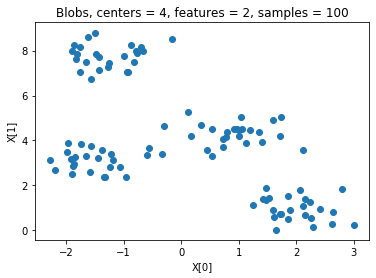

In [343]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.title("Blobs, centers = 4, features = 2, samples = 100")

In [344]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.25, random_state=0)

<h4>Scratch training</h4>

In [345]:
kmeans_scratch = ScratchKMeans(n_clusters=8)
kmeans_scratch.fit(X_train)
kmeans_scratch.predict(X_test)

<ipython-input-341-5607adba2312>:68: RuntimeWarning: Mean of empty slice.
  mu[k, :] = X[r[:, k] == 1].mean(axis=0)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [346]:
kmeans_scratch.SSE

nan

<h4>Sklearn training</h4>

In [347]:
from sklearn.cluster import KMeans

kmeans_sklearn = KMeans(n_clusters=8)
kmeans_sklearn.fit(X_train)
kmeans_sklearn.predict(X_test)

array([4, 0, 5, 2, 5, 4, 0, 2, 3, 2, 4, 1, 6, 7, 7, 6, 3, 1, 0, 1, 4, 0,
       1, 0, 7], dtype=int32)

In [348]:
kmeans_sklearn.inertia_

22.013289234471053

<h3>[Problem 8] Implementation of elbow method</h3>

In [349]:
def elbow_method(X, head_k, tail_k):
    SSE_list = []
    k_list = []
    for k in range(head_k, tail_k + 1):
        model = ScratchKMeans(n_clusters=k, n_init=100, max_iter=100, tol=1e-4, verbose=False)
        model.fit(X)
        SSE_list.append(model.SSE)
        k_list.append(k)
    return SSE_list, k_list

In [350]:
SSE_list, k_list = elbow_method(
            X=X,
            head_k=1,
            tail_k=20
            )
print("SSE_list: \n {}".format(SSE_list))
print("k_list: \n {}".format(k_list))

<ipython-input-341-5607adba2312>:68: RuntimeWarning: Mean of empty slice.
  mu[k, :] = X[r[:, k] == 1].mean(axis=0)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
SSE_list: 
 [870.2611797855423, 351.4837286512544, 139.17097772033804, 48.63378320706403, 42.9674947017524, 37.741898696818815, nan, nan, nan, nan, 20.27837886764052, nan, nan, 14.928392135331846, 14.69730447459535, 12.39562594358791, 11.998819627157207, nan, 9.771467651269925, nan]
k_list: 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Text(0.5, 1.0, 'SSE graph')

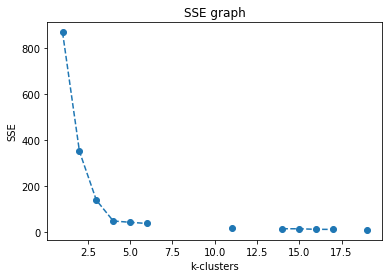

In [351]:
plt.plot(k_list, SSE_list, 'o--')
plt.xlabel("k-clusters")
plt.ylabel("SSE")
plt.title("SSE graph")

According to the plot, we can see that optimum clusters is 4, due to the "elbow" point.

<h3>Wholesaler data </h3>

In [352]:
import pandas as pd

In [353]:
data = pd.read_csv('./Wholesale customers data.csv')
display(data.head())
display(data.shape)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


(440, 8)

In [354]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data.iloc[:, 2:])
data_pca = pca.transform(data.iloc[:, 2:])

display(pca.explained_variance_ratio_)
display(data_pca[:5])

array([0.45961362, 0.40517227])

array([[  650.02212207,  1585.51909007],
       [-4426.80497937,  4042.45150884],
       [-4841.9987068 ,  2578.762176  ],
       [  990.34643689, -6279.80599663],
       [10657.99873116, -2159.72581518]])

Text(0.5, 1.0, 'data after PCA')

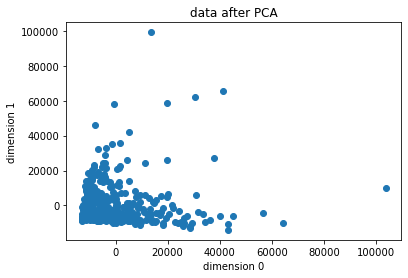

In [355]:
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlabel("dimension 0")
plt.ylabel("dimension 1")
plt.title("data after PCA")

<h3>[Problem 10] Selection of the number of clusters k</h3>

In [356]:
SSE_list, k_list = elbow_method(
            X=data_pca,
            head_k=1,
            tail_k=20
            )
print("SSE_list: \n {}".format(SSE_list))
print("k_list: \n {}".format(k_list))

SSE_list: 
 [136286672801.69916, 91919932364.82275, 59083142617.61933, 43781540468.914925, 32044670443.780136, 26535916698.1926, 21211758738.84102, 18312359085.613495, 16527619623.377747, 14808642135.014677, 13395845058.958963, 11881114212.130642, 10469482447.152012, 10282354805.402578, 9397720097.270098, 8465418357.7233715, 8165958949.2815075, 7282029902.650776, 7241412308.972908, 6827926615.527498]
k_list: 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Text(0.5, 1.0, 'SSE graph')

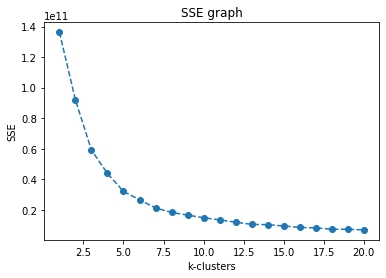

In [357]:
plt.plot(k_list, SSE_list, 'o--')
plt.xlabel("k-clusters")
plt.ylabel("SSE")
plt.title("SSE graph")

According to the plot, we can guest that optimum clusters is somewhat ~6, due to the "elbow" point connecting the huge drop in SSE and a linearly parts of SSE.

<h3>[Problem 11] Comparison with known groups</h3>

These known groups are different from the previous clusters, because it it in the discrete (label) forms, rather than continuous values. Therefore, I will plot these samples as a bar plot with separated groups.

Channel:


1    298
2    142
Name: Channel, dtype: int64

Text(0.5, 1.0, 'Channel groups')

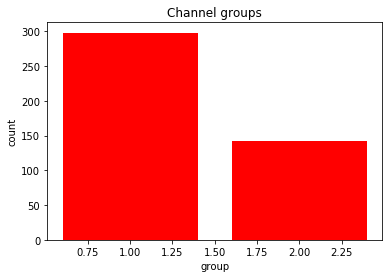

In [358]:
print("Channel:")
display(data.iloc[:, 0].value_counts())

plt.bar(data.iloc[:, 0].value_counts().index, data.iloc[:, 0].value_counts(), color='red')
plt.xlabel("group")
plt.ylabel("count")
plt.title("Channel groups")


The number samples in group 1 is doubled group 2.

Region:


3    316
1     77
2     47
Name: Region, dtype: int64

Text(0.5, 1.0, 'Region groups')

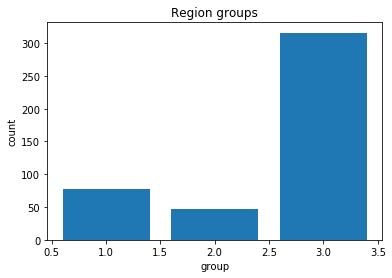

In [359]:
print("Region:")
display(data.iloc[:, 1].value_counts())

plt.bar(data.iloc[:, 1].value_counts().index, data.iloc[:, 1].value_counts())
plt.xlabel("group")
plt.ylabel("count")
plt.title("Region groups")

There are 3 regions 1, 2, 3 that a samples can be in. The group 3 has the highest number of samples, whereas group 2 has the lowest number of samples.

<h3>[Problem 12] Useful information for wholesalers</h3>

In [360]:
data_group = data.groupby(by=['Channel', 'Region'])
data_group.count()

Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
Channel Region                                                            
1       1          59    59       59      59                59          59
        2          28    28       28      28                28          28
        3         211   211      211     211               211         211
2       1          18    18       18      18                18          18
        2          19    19       19      19                19          19
        3         105   105      105     105               105         105

When combining these 2 known groups, we get 6 separated groups.

In [421]:
print("Number of samples per groups:\n{}".format(data_group.count().iloc[:, 0]))
print("sorted: {}".format(sorted(data_group.count().iloc[:, 0])))

Number of samples per groups:
Channel  Region
1        1          59
         2          28
         3         211
2        1          18
         2          19
         3         105
Name: Fresh, dtype: int64
sorted: [18, 19, 28, 59, 105, 211]


Group (Channel 1, Region 3) has the highest samples. Whereas (Channel 2, Region 1) has the lowest samples.

Let's try to use KMeans to seperated data into 6 clusters, according to the 6 groups

In [423]:
model = ScratchKMeans(n_clusters=6, n_init=300, max_iter=2000)
model.fit(data.iloc[:, 2:].to_numpy())
print("Number of samples per clusters:\n{}".format(sorted(model.r.sum(axis=0))))

Number of samples per clusters:
[3.0, 7.0, 22.0, 80.0, 104.0, 224.0]


Surprisingly, we can see the cluster with the highest number of samples (224) is approximately the group (Channel 1, Region 3) (211), and more!

In [431]:
data_group.mean()

Fresh          Milk       Grocery       Frozen  \
Channel Region                                                          
1       1       12902.254237   3870.203390   4026.135593  3127.322034   
        2       11650.535714   2304.250000   4395.500000  5745.035714   
        3       13878.052133   3486.981043   3886.734597  3656.900474   
2       1        5200.000000  10784.000000  18471.944444  2584.111111   
        2        7289.789474   9190.789474  16326.315789  1540.578947   
        3        9831.504762  10981.009524  15953.809524  1513.200000   

                Detergents_Paper   Delicassen  
Channel Region                                 
1       1             950.525424  1197.152542  
        2             482.714286  1105.892857  
        3             786.682464  1518.284360  
2       1            8225.277778  1871.944444  
        2            8410.263158  1239.000000  
        3            6899.238095  1826.209524

In [429]:
np.round(model.mu, 2)

array([[ 4724.21, 11837.01, 18461.59,  1546.58,  8195.89,  1638.65],
       [21200.06,  3886.42,  5138.93,  4119.86,  1131.52,  1690.34],
       [20031.29, 38084.  , 56126.14,  2564.57, 27644.57,  2548.14],
       [50049.68,  4447.41,  5225.05,  5895.64,   948.18,  2404.36],
       [31979.  , 32385.67, 18605.  , 34185.67,  1949.33, 23358.33],
       [ 6072.05,  3292.95,  4122.93,  2451.99,  1224.5 ,   996.64]])

According to the data_group mean and the centers of KMeans for each cluster, we can see the money spent for each feature is different for each group, which represent the group's characteristics. This can be seen clearly by categorized into Channel.